WIP notebook to test the VAE-based counterfactual data augmentation module from CLAIRE on a dummy dataset.

Implemention at `src/claire_cf_data_augmentation.py`.

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

# Dummy data

In [3]:
class DummyDataset(Dataset):
    def __init__(self, X, Y, S):
        """
        Args:
            X: Input features
            Y: Labels
            S: Sensitive attributes
        """
        self.X = X
        self.Y = Y
        self.S = S

    def __len__(self):
        """Return the total number of samples."""
        return len(self.X)

    def __getitem__(self, idx):
        """Return a single sample from the dataset at index `idx`."""
        x = self.X[idx]
        y = self.Y[idx]
        s = self.S[idx]
        return x, y, s

In [6]:
X_train_example = torch.randn(1000, 2)  # Input features X
Y_train_example = torch.randint(0, 2, (1000, 1))  # Labels Y (binary)
S_train_example = torch.randint(0, 2, (1000, 1))  # Sensitive attribute S (binary)

X_train_example.shape, Y_train_example.shape, S_train_example.shape 

(torch.Size([1000, 2]), torch.Size([1000, 1]), torch.Size([1000, 1]))

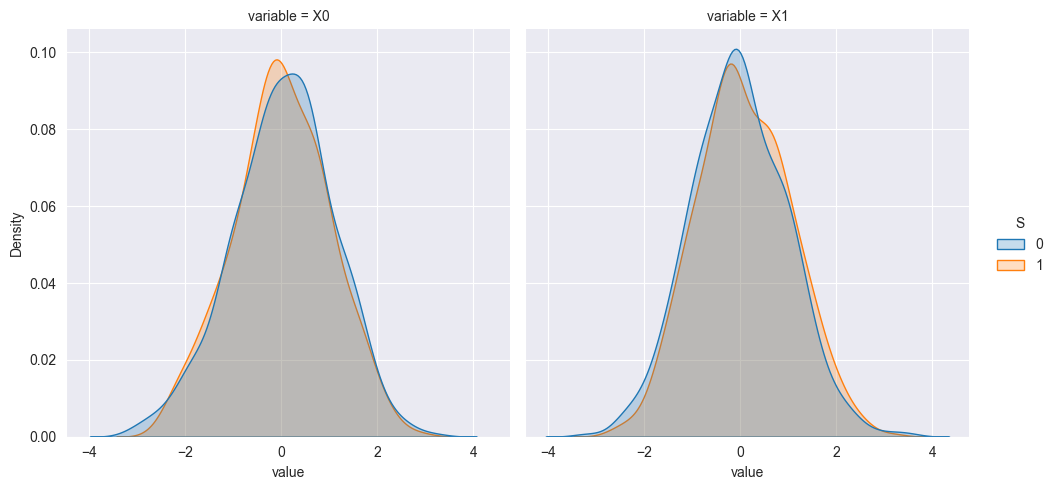

In [7]:
orig_df = pd.DataFrame(X_train_example, columns=[f"X{i}" for i in range(X_train_example.shape[1])])
orig_df["S"] = S_train_example
orig_df["Y"] = Y_train_example

orig_df_long = orig_df.melt(id_vars=["S", "Y"], var_name="variable", value_name="value")
sns.displot(orig_df_long, x="value", hue="S", col="variable", kind="kde", fill=True)

In [8]:
train_dataset = DummyDataset(X_train_example, Y_train_example, S_train_example)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

In [9]:
len(train_dataloader)  # Number of batches in the dataloader

31

In [10]:
len(train_dataloader) * train_dataloader.batch_size  # Number of samples in the dataloader

992

## VAE loss

In [11]:
from src.claire_cf_data_augmentation import vae_loss

In [13]:
xy_true = torch.randn(32, 10)   # Original input
xy_recon = torch.randn(32, 10)  # Reconstructed input
mu = torch.randn(32, 20)        # Mean from the encoder's latent space
logvar = torch.randn(32, 20)    # Log variance from the encoder's latent space

x_recon = xy_recon[:, :-1] 
y_recon = torch.sigmoid(xy_recon[:, -1].unsqueeze(1))
# xy_recon = torch.cat([x_recon, y_recon], dim=1)
    
x_true = xy_true[:, :-1] 
y_true = torch.sigmoid(xy_true[:, -1].unsqueeze(1))
# xy_true = torch.cat([x_true, y_true], dim=1)
    
vae_loss(x_true, y_true, x_recon, y_recon, mu, logvar)

tensor(18.6972)

In [14]:
vae_loss(x_true, y_true, x_true, y_true, mu, logvar)

tensor(16.8558)

## MMD loss

- Small if two distributions are similar and large if they are different.

In [15]:
from src.claire_cf_data_augmentation import mmd_loss

In [16]:
H1 = torch.randn(1, 20) 
H2 = H1.clone()

mmd_loss(H1, H2)

tensor(0.)

In [17]:
H3 = H1.clone() + 0.1

mmd_loss(H1, H3)

tensor(0.1903)

## CLAIRE-M loss function

In [18]:
from src.claire_cf_data_augmentation import claire_m_loss

vae_loss = torch.tensor(1.0) 

embeddings_by_group = {
    'group1': torch.randn(32, 10),
    'group2': torch.randn(32, 10),
}

loss = claire_m_loss(vae_loss, embeddings_by_group)
print("CLAIRE-M Loss:", loss.item())

CLAIRE-M Loss: 1.1241929531097412


## Train VAE for counterfactual data generation

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
from src.claire_cf_data_augmentation import VAE

vae_example = VAE(input_dim=X_train_example.shape[1], latent_dim=20)
vae_example.to(device)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=3, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=20, bias=True)
    (fc_var): Linear(in_features=32, out_features=20, bias=True)
    (activation): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=21, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=3, bias=True)
    (activation): LeakyReLU(negative_slope=0.01)
  )
)

In [23]:
from src.claire_cf_data_augmentation import train

vae_example, vae_example_train_loss = train(vae_example, train_dataloader, num_epochs=100)

  1%|          | 1/100 [00:00<00:17,  5.63epochs/s]

Epoch [1/100], Loss: 3.3438


  2%|▏         | 2/100 [00:00<00:22,  4.37epochs/s]

Epoch [2/100], Loss: 3.1381


  3%|▎         | 3/100 [00:00<00:17,  5.60epochs/s]

Epoch [3/100], Loss: 2.9704


  4%|▍         | 4/100 [00:00<00:16,  5.99epochs/s]

Epoch [4/100], Loss: 2.8489


  5%|▌         | 5/100 [00:00<00:14,  6.71epochs/s]

Epoch [5/100], Loss: 2.7227


  6%|▌         | 6/100 [00:00<00:13,  7.18epochs/s]

Epoch [6/100], Loss: 2.6241


  7%|▋         | 7/100 [00:01<00:12,  7.60epochs/s]

Epoch [7/100], Loss: 2.5452


  8%|▊         | 8/100 [00:01<00:11,  7.85epochs/s]

Epoch [8/100], Loss: 2.4590


  9%|▉         | 9/100 [00:01<00:11,  8.18epochs/s]

Epoch [9/100], Loss: 2.4086


 10%|█         | 10/100 [00:01<00:10,  8.41epochs/s]

Epoch [10/100], Loss: 2.3661


 11%|█         | 11/100 [00:01<00:10,  8.44epochs/s]

Epoch [11/100], Loss: 2.3187


 12%|█▏        | 12/100 [00:01<00:10,  8.18epochs/s]

Epoch [12/100], Loss: 2.2982


 13%|█▎        | 13/100 [00:01<00:10,  7.99epochs/s]

Epoch [13/100], Loss: 2.2303


 14%|█▍        | 14/100 [00:01<00:10,  7.86epochs/s]

Epoch [14/100], Loss: 2.2099


 15%|█▌        | 15/100 [00:02<00:10,  7.95epochs/s]

Epoch [15/100], Loss: 2.1843


 16%|█▌        | 16/100 [00:02<00:12,  6.94epochs/s]

Epoch [16/100], Loss: 2.1626


 17%|█▋        | 17/100 [00:02<00:11,  7.18epochs/s]

Epoch [17/100], Loss: 2.1426


 18%|█▊        | 18/100 [00:02<00:11,  7.18epochs/s]

Epoch [18/100], Loss: 2.1261


 19%|█▉        | 19/100 [00:02<00:14,  5.48epochs/s]

Epoch [19/100], Loss: 2.1016


 20%|██        | 20/100 [00:02<00:15,  5.17epochs/s]

Epoch [20/100], Loss: 2.0978


 21%|██        | 21/100 [00:03<00:14,  5.51epochs/s]

Epoch [21/100], Loss: 2.0803


 22%|██▏       | 22/100 [00:03<00:12,  6.02epochs/s]

Epoch [22/100], Loss: 2.0820


 23%|██▎       | 23/100 [00:03<00:11,  6.61epochs/s]

Epoch [23/100], Loss: 2.0829


 24%|██▍       | 24/100 [00:03<00:11,  6.87epochs/s]

Epoch [24/100], Loss: 2.0538


 25%|██▌       | 25/100 [00:03<00:11,  6.48epochs/s]

Epoch [25/100], Loss: 2.0530


 26%|██▌       | 26/100 [00:03<00:11,  6.43epochs/s]

Epoch [26/100], Loss: 2.0372


 27%|██▋       | 27/100 [00:04<00:11,  6.58epochs/s]

Epoch [27/100], Loss: 2.0467


 28%|██▊       | 28/100 [00:04<00:10,  6.65epochs/s]

Epoch [28/100], Loss: 2.0404


 29%|██▉       | 29/100 [00:04<00:10,  6.95epochs/s]

Epoch [29/100], Loss: 2.0469


 30%|███       | 30/100 [00:04<00:09,  7.00epochs/s]

Epoch [30/100], Loss: 2.0386


 31%|███       | 31/100 [00:04<00:12,  5.68epochs/s]

Epoch [31/100], Loss: 2.0260


 32%|███▏      | 32/100 [00:04<00:10,  6.28epochs/s]

Epoch [32/100], Loss: 2.0241


 33%|███▎      | 33/100 [00:04<00:10,  6.54epochs/s]

Epoch [33/100], Loss: 2.0306


 34%|███▍      | 34/100 [00:05<00:09,  6.85epochs/s]

Epoch [34/100], Loss: 2.0171


 35%|███▌      | 35/100 [00:05<00:09,  7.16epochs/s]

Epoch [35/100], Loss: 2.0162


 36%|███▌      | 36/100 [00:05<00:08,  7.41epochs/s]

Epoch [36/100], Loss: 2.0166


 37%|███▋      | 37/100 [00:05<00:08,  7.62epochs/s]

Epoch [37/100], Loss: 2.0095


 38%|███▊      | 38/100 [00:05<00:08,  7.66epochs/s]

Epoch [38/100], Loss: 2.0213


 39%|███▉      | 39/100 [00:05<00:07,  7.80epochs/s]

Epoch [39/100], Loss: 2.0066


 40%|████      | 40/100 [00:06<00:12,  4.67epochs/s]

Epoch [40/100], Loss: 2.0012


 41%|████      | 41/100 [00:06<00:12,  4.78epochs/s]

Epoch [41/100], Loss: 2.0080


 42%|████▏     | 42/100 [00:06<00:10,  5.36epochs/s]

Epoch [42/100], Loss: 2.0050


 43%|████▎     | 43/100 [00:06<00:09,  5.95epochs/s]

Epoch [43/100], Loss: 2.0031


 44%|████▍     | 44/100 [00:06<00:08,  6.52epochs/s]

Epoch [44/100], Loss: 1.9952


 45%|████▌     | 45/100 [00:06<00:07,  6.98epochs/s]

Epoch [45/100], Loss: 2.0030


 46%|████▌     | 46/100 [00:06<00:07,  7.26epochs/s]

Epoch [46/100], Loss: 2.0000


 47%|████▋     | 47/100 [00:07<00:06,  7.60epochs/s]

Epoch [47/100], Loss: 1.9970


 48%|████▊     | 48/100 [00:07<00:06,  8.01epochs/s]

Epoch [48/100], Loss: 2.0001


 49%|████▉     | 49/100 [00:07<00:06,  8.19epochs/s]

Epoch [49/100], Loss: 1.9801


 50%|█████     | 50/100 [00:07<00:07,  7.08epochs/s]

Epoch [50/100], Loss: 1.9987


 51%|█████     | 51/100 [00:07<00:07,  6.32epochs/s]

Epoch [51/100], Loss: 1.9926


 52%|█████▏    | 52/100 [00:07<00:08,  5.77epochs/s]

Epoch [52/100], Loss: 1.9999


 53%|█████▎    | 53/100 [00:08<00:08,  5.79epochs/s]

Epoch [53/100], Loss: 1.9988


 54%|█████▍    | 54/100 [00:08<00:07,  5.81epochs/s]

Epoch [54/100], Loss: 1.9970


 55%|█████▌    | 55/100 [00:08<00:08,  5.45epochs/s]

Epoch [55/100], Loss: 2.0055


 56%|█████▌    | 56/100 [00:08<00:07,  5.98epochs/s]

Epoch [56/100], Loss: 1.9942


 57%|█████▋    | 57/100 [00:08<00:06,  6.64epochs/s]

Epoch [57/100], Loss: 2.0055


 58%|█████▊    | 58/100 [00:08<00:05,  7.22epochs/s]

Epoch [58/100], Loss: 1.9964


 59%|█████▉    | 59/100 [00:08<00:05,  7.58epochs/s]

Epoch [59/100], Loss: 2.0034


 60%|██████    | 60/100 [00:08<00:05,  7.93epochs/s]

Epoch [60/100], Loss: 1.9860


 61%|██████    | 61/100 [00:09<00:04,  8.18epochs/s]

Epoch [61/100], Loss: 1.9943


 62%|██████▏   | 62/100 [00:09<00:04,  8.44epochs/s]

Epoch [62/100], Loss: 1.9886


 63%|██████▎   | 63/100 [00:09<00:04,  8.37epochs/s]

Epoch [63/100], Loss: 1.9874


 64%|██████▍   | 64/100 [00:09<00:04,  8.17epochs/s]

Epoch [64/100], Loss: 1.9747


 65%|██████▌   | 65/100 [00:09<00:04,  8.00epochs/s]

Epoch [65/100], Loss: 1.9847


 66%|██████▌   | 66/100 [00:09<00:04,  7.00epochs/s]

Epoch [66/100], Loss: 1.9781


 67%|██████▋   | 67/100 [00:10<00:05,  5.92epochs/s]

Epoch [67/100], Loss: 1.9810


 68%|██████▊   | 68/100 [00:10<00:05,  5.98epochs/s]

Epoch [68/100], Loss: 1.9964


 69%|██████▉   | 69/100 [00:10<00:05,  6.15epochs/s]

Epoch [69/100], Loss: 1.9762


 70%|███████   | 70/100 [00:10<00:04,  6.52epochs/s]

Epoch [70/100], Loss: 1.9772


 71%|███████   | 71/100 [00:10<00:04,  6.76epochs/s]

Epoch [71/100], Loss: 2.0023


 72%|███████▏  | 72/100 [00:10<00:04,  6.24epochs/s]

Epoch [72/100], Loss: 1.9834


 73%|███████▎  | 73/100 [00:10<00:04,  6.33epochs/s]

Epoch [73/100], Loss: 1.9959


 74%|███████▍  | 74/100 [00:11<00:04,  6.46epochs/s]

Epoch [74/100], Loss: 1.9982


 75%|███████▌  | 75/100 [00:11<00:03,  6.41epochs/s]

Epoch [75/100], Loss: 1.9730


 76%|███████▌  | 76/100 [00:11<00:03,  6.32epochs/s]

Epoch [76/100], Loss: 1.9798


 77%|███████▋  | 77/100 [00:11<00:03,  6.15epochs/s]

Epoch [77/100], Loss: 1.9724


 78%|███████▊  | 78/100 [00:11<00:03,  6.32epochs/s]

Epoch [78/100], Loss: 1.9704


 79%|███████▉  | 79/100 [00:11<00:03,  6.35epochs/s]

Epoch [79/100], Loss: 1.9718


 80%|████████  | 80/100 [00:12<00:02,  6.69epochs/s]

Epoch [80/100], Loss: 1.9781


 81%|████████  | 81/100 [00:12<00:02,  7.04epochs/s]

Epoch [81/100], Loss: 1.9728


 82%|████████▏ | 82/100 [00:12<00:02,  7.23epochs/s]

Epoch [82/100], Loss: 1.9860


 83%|████████▎ | 83/100 [00:12<00:02,  7.57epochs/s]

Epoch [83/100], Loss: 1.9834


 84%|████████▍ | 84/100 [00:12<00:02,  7.66epochs/s]

Epoch [84/100], Loss: 1.9856


 85%|████████▌ | 85/100 [00:12<00:01,  7.88epochs/s]

Epoch [85/100], Loss: 1.9780


 86%|████████▌ | 86/100 [00:12<00:01,  8.10epochs/s]

Epoch [86/100], Loss: 1.9853


 87%|████████▋ | 87/100 [00:12<00:01,  8.07epochs/s]

Epoch [87/100], Loss: 1.9709


 88%|████████▊ | 88/100 [00:12<00:01,  8.03epochs/s]

Epoch [88/100], Loss: 1.9752


 89%|████████▉ | 89/100 [00:13<00:01,  8.15epochs/s]

Epoch [89/100], Loss: 1.9634


 90%|█████████ | 90/100 [00:13<00:01,  8.20epochs/s]

Epoch [90/100], Loss: 1.9751


 91%|█████████ | 91/100 [00:13<00:01,  8.37epochs/s]

Epoch [91/100], Loss: 1.9793


 92%|█████████▏| 92/100 [00:13<00:00,  8.47epochs/s]

Epoch [92/100], Loss: 1.9847


 93%|█████████▎| 93/100 [00:13<00:00,  8.43epochs/s]

Epoch [93/100], Loss: 1.9825


 94%|█████████▍| 94/100 [00:13<00:00,  8.36epochs/s]

Epoch [94/100], Loss: 1.9861


 95%|█████████▌| 95/100 [00:13<00:00,  8.25epochs/s]

Epoch [95/100], Loss: 1.9685


 96%|█████████▌| 96/100 [00:13<00:00,  8.28epochs/s]

Epoch [96/100], Loss: 1.9717


 97%|█████████▋| 97/100 [00:14<00:00,  8.27epochs/s]

Epoch [97/100], Loss: 1.9854


 98%|█████████▊| 98/100 [00:14<00:00,  8.20epochs/s]

Epoch [98/100], Loss: 1.9885


 99%|█████████▉| 99/100 [00:14<00:00,  8.14epochs/s]

Epoch [99/100], Loss: 1.9792


100%|██████████| 100/100 [00:14<00:00,  6.93epochs/s]

Epoch [100/100], Loss: 1.9801


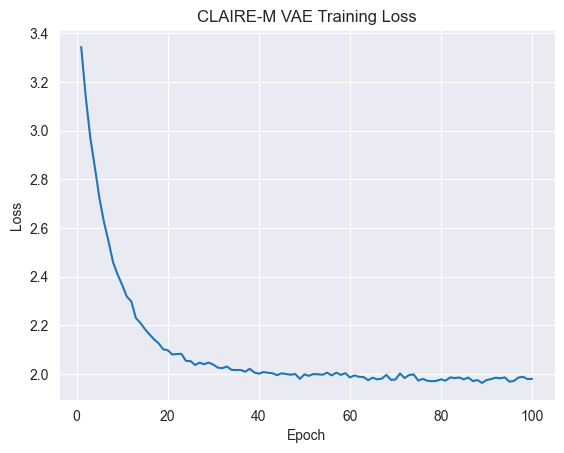

In [24]:
plt.plot(range(1, len(vae_example_train_loss) + 1), vae_example_train_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CLAIRE-M VAE Training Loss")
plt.show()

## Generate counterfactuals

In [25]:
from src.claire_cf_data_augmentation import CounterfactualDataGenerator

cf_gen = CounterfactualDataGenerator(vae_example, sensitive_groups=[0, 1], K=20)

In [32]:
train_dataset = DummyDataset(X_train_example, Y_train_example, S_train_example)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

X_CF = {0: [], 1: []}
Y_CF = {0: [], 1: []}

for X_batch, Y_batch, S_batch in train_dataloader:
    X_cf_batch, Y_cf_batch = cf_gen.generate_counterfactuals(X_batch, Y_batch)
    for s in X_cf_batch.keys():
        X_CF[s].append(X_cf_batch[s])
        Y_CF[s].append(Y_cf_batch[s])

In [33]:
cf0_df = pd.DataFrame(np.vstack(X_CF[0]), columns=[f"X{i}" for i in range(X_train_example.shape[1])])
cf0_df["S"] = 0
cf0_df["Y"] = np.vstack(Y_CF[0])

cf1_df = pd.DataFrame(np.vstack(X_CF[1]), columns=[f"X{i}" for i in range(X_train_example.shape[1])])
cf1_df["S"] = 1
cf1_df["Y"] = np.vstack(Y_CF[1])

cf_df = pd.concat([cf0_df, cf1_df], ignore_index=True)

In [34]:
len(orig_df), len(cf_df)

(1000, 1984)

In [35]:
cf_df["Y"].value_counts()

Y
0.0    1755
1.0     229
Name: count, dtype: int64

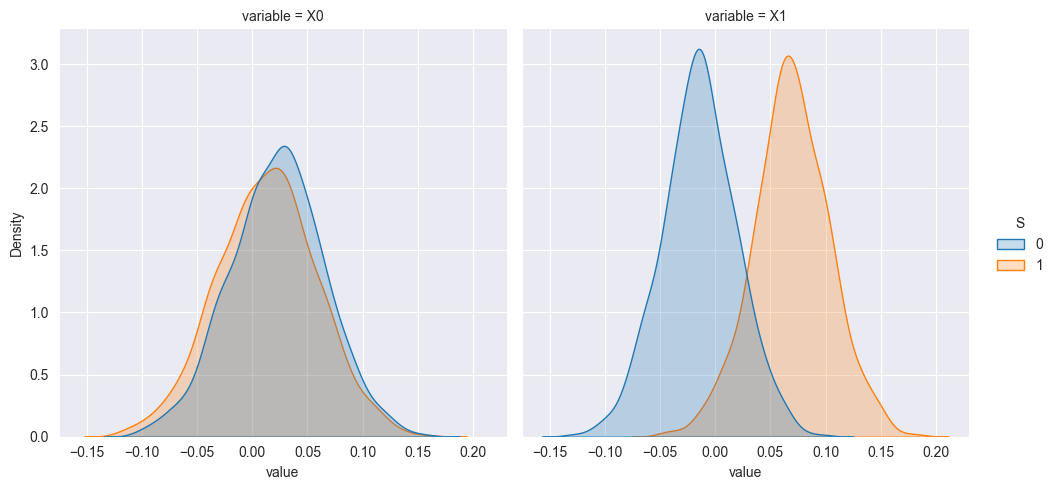

In [36]:
# sns.pairplot(cf_df, hue="S", diag_kind="kde", corner=True)
cf_df_long = cf_df.melt(id_vars=["S", "Y"], var_name="variable", value_name="value")
sns.displot(cf_df_long, x="value", hue="S", col="variable", kind="kde", fill=True)

# Adult dataset (sensitive attribute: "sex")

In [37]:
from src.datasets import IncomeDataset
from torch.utils.data import DataLoader

In [38]:
train_df = pd.read_csv(IncomeDataset.PATHS["train_basis"])
train_df.head()

,sex,education_num,age,income
0,0,10.0,20,0
1,0,4.0,60,0
2,1,9.0,60,1
3,0,10.0,40,0
4,1,14.0,60,1


In [39]:
train_df.income.value_counts()

income
0    11179
1     3474
Name: count, dtype: int64

In [44]:
train_dataset = IncomeDataset(split="train_basis", sensitive_attribute="sex", to_tensor=True)

print("Sensitive attribute:", train_dataset.S_name)
print("Input features:", train_dataset.X_names)
print("Target variable:", train_dataset.Y_name)

Sensitive attribute: sex
Input features: ['education_num', 'age']
Target variable: income


In [45]:
train_dataset.X.shape, train_dataset.Y.shape, train_dataset.S.shape

(torch.Size([14653, 2]), torch.Size([14653, 1]), torch.Size([14653, 1]))

In [46]:
train_dataset.Y.unique()

tensor([0., 1.])

In [47]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

## Train VAE

In [48]:
import torch
from src.claire_cf_data_augmentation import VAE, train

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [50]:
vae = VAE(input_dim=len(train_dataset.X_names), latent_dim=8, hidden_dim=16)
vae.to(device)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=3, out_features=16, bias=True)
    (fc_mu): Linear(in_features=16, out_features=8, bias=True)
    (fc_var): Linear(in_features=16, out_features=8, bias=True)
    (activation): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=9, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=3, bias=True)
    (activation): LeakyReLU(negative_slope=0.01)
  )
)

In [51]:
vae, vae_train_loss = train(vae, train_dataloader, num_epochs=100)

  1%|          | 1/100 [00:01<03:01,  1.83s/epochs]

Epoch [1/100], Loss: 36304757.6334


  2%|▏         | 2/100 [00:03<02:58,  1.82s/epochs]

Epoch [2/100], Loss: 7552657.2338


  3%|▎         | 3/100 [00:05<02:59,  1.85s/epochs]

Epoch [3/100], Loss: 3567307.9304


  4%|▍         | 4/100 [00:07<02:55,  1.82s/epochs]

Epoch [4/100], Loss: 1970623.0149


  5%|▌         | 5/100 [00:09<02:56,  1.86s/epochs]

Epoch [5/100], Loss: 1222865.5644


  6%|▌         | 6/100 [00:11<02:55,  1.86s/epochs]

Epoch [6/100], Loss: 780702.3324


  7%|▋         | 7/100 [00:13<03:03,  1.97s/epochs]

Epoch [7/100], Loss: 520662.9301


  8%|▊         | 8/100 [00:15<03:00,  1.96s/epochs]

Epoch [8/100], Loss: 362422.9716


  9%|▉         | 9/100 [00:17<02:57,  1.95s/epochs]

Epoch [9/100], Loss: 259531.2718


 10%|█         | 10/100 [00:19<03:14,  2.16s/epochs]

Epoch [10/100], Loss: 187811.2021


 11%|█         | 11/100 [00:22<03:17,  2.22s/epochs]

Epoch [11/100], Loss: 138534.4952


 12%|█▏        | 12/100 [00:24<03:16,  2.24s/epochs]

Epoch [12/100], Loss: 103921.2721


 13%|█▎        | 13/100 [00:26<03:14,  2.24s/epochs]

Epoch [13/100], Loss: 79100.3945


 14%|█▍        | 14/100 [00:28<03:05,  2.16s/epochs]

Epoch [14/100], Loss: 60507.8470


 15%|█▌        | 15/100 [00:30<02:59,  2.11s/epochs]

Epoch [15/100], Loss: 46513.9556


 16%|█▌        | 16/100 [00:32<02:54,  2.08s/epochs]

Epoch [16/100], Loss: 35984.3385


 17%|█▋        | 17/100 [00:34<02:51,  2.07s/epochs]

Epoch [17/100], Loss: 27944.8986


 18%|█▊        | 18/100 [00:36<02:51,  2.09s/epochs]

Epoch [18/100], Loss: 21653.5988


 19%|█▉        | 19/100 [00:39<02:53,  2.14s/epochs]

Epoch [19/100], Loss: 16913.2188


 20%|██        | 20/100 [00:41<02:49,  2.12s/epochs]

Epoch [20/100], Loss: 13353.9375


 21%|██        | 21/100 [00:44<03:08,  2.39s/epochs]

Epoch [21/100], Loss: 10512.0665


 22%|██▏       | 22/100 [00:46<03:07,  2.40s/epochs]

Epoch [22/100], Loss: 8230.2793


 23%|██▎       | 23/100 [00:49<03:08,  2.45s/epochs]

Epoch [23/100], Loss: 6468.3189


 24%|██▍       | 24/100 [00:51<03:11,  2.52s/epochs]

Epoch [24/100], Loss: 5107.3094


 25%|██▌       | 25/100 [00:54<03:04,  2.46s/epochs]

Epoch [25/100], Loss: 4026.0450


 26%|██▌       | 26/100 [00:56<02:57,  2.39s/epochs]

Epoch [26/100], Loss: 3190.8654


 27%|██▋       | 27/100 [00:58<02:55,  2.40s/epochs]

Epoch [27/100], Loss: 2516.5009


 28%|██▊       | 28/100 [01:01<02:57,  2.47s/epochs]

Epoch [28/100], Loss: 2014.1609


 29%|██▉       | 29/100 [01:03<02:53,  2.44s/epochs]

Epoch [29/100], Loss: 1601.3545


 30%|███       | 30/100 [01:06<02:47,  2.40s/epochs]

Epoch [30/100], Loss: 1277.8260


 31%|███       | 31/100 [01:08<02:40,  2.33s/epochs]

Epoch [31/100], Loss: 1018.8959


 32%|███▏      | 32/100 [01:10<02:45,  2.43s/epochs]

Epoch [32/100], Loss: 817.1058


 33%|███▎      | 33/100 [01:13<02:51,  2.55s/epochs]

Epoch [33/100], Loss: 655.4270


 34%|███▍      | 34/100 [01:16<02:47,  2.54s/epochs]

Epoch [34/100], Loss: 527.6412


 35%|███▌      | 35/100 [01:18<02:44,  2.53s/epochs]

Epoch [35/100], Loss: 425.0395


 36%|███▌      | 36/100 [01:21<02:38,  2.48s/epochs]

Epoch [36/100], Loss: 344.9243


 37%|███▋      | 37/100 [01:23<02:35,  2.47s/epochs]

Epoch [37/100], Loss: 280.4526


 38%|███▊      | 38/100 [01:26<02:31,  2.44s/epochs]

Epoch [38/100], Loss: 228.3286


 39%|███▉      | 39/100 [01:28<02:28,  2.43s/epochs]

Epoch [39/100], Loss: 187.3341


 40%|████      | 40/100 [01:30<02:24,  2.41s/epochs]

Epoch [40/100], Loss: 154.7024


 41%|████      | 41/100 [01:33<02:20,  2.39s/epochs]

Epoch [41/100], Loss: 128.3893


 42%|████▏     | 42/100 [01:35<02:20,  2.42s/epochs]

Epoch [42/100], Loss: 107.3636


 43%|████▎     | 43/100 [01:38<02:20,  2.46s/epochs]

Epoch [43/100], Loss: 90.3274


 44%|████▍     | 44/100 [01:40<02:17,  2.45s/epochs]

Epoch [44/100], Loss: 76.7716


 45%|████▌     | 45/100 [01:43<02:17,  2.51s/epochs]

Epoch [45/100], Loss: 65.8908


 46%|████▌     | 46/100 [01:45<02:19,  2.58s/epochs]

Epoch [46/100], Loss: 57.1334


 47%|████▋     | 47/100 [01:48<02:19,  2.64s/epochs]

Epoch [47/100], Loss: 50.0834


 48%|████▊     | 48/100 [01:51<02:12,  2.54s/epochs]

Epoch [48/100], Loss: 44.2021


 49%|████▉     | 49/100 [01:53<02:04,  2.44s/epochs]

Epoch [49/100], Loss: 39.5047


 50%|█████     | 50/100 [01:55<01:57,  2.35s/epochs]

Epoch [50/100], Loss: 35.6470


 51%|█████     | 51/100 [01:57<01:51,  2.28s/epochs]

Epoch [51/100], Loss: 32.5202


 52%|█████▏    | 52/100 [01:59<01:46,  2.22s/epochs]

Epoch [52/100], Loss: 29.7933


 53%|█████▎    | 53/100 [02:01<01:44,  2.22s/epochs]

Epoch [53/100], Loss: 27.5341


 54%|█████▍    | 54/100 [02:04<01:43,  2.25s/epochs]

Epoch [54/100], Loss: 25.5877


 55%|█████▌    | 55/100 [02:06<01:45,  2.34s/epochs]

Epoch [55/100], Loss: 23.9391


 56%|█████▌    | 56/100 [02:09<01:49,  2.50s/epochs]

Epoch [56/100], Loss: 22.5072


 57%|█████▋    | 57/100 [02:12<01:47,  2.50s/epochs]

Epoch [57/100], Loss: 21.2602


 58%|█████▊    | 58/100 [02:14<01:46,  2.54s/epochs]

Epoch [58/100], Loss: 20.2098


 59%|█████▉    | 59/100 [02:17<01:42,  2.49s/epochs]

Epoch [59/100], Loss: 19.2307


 60%|██████    | 60/100 [02:19<01:37,  2.45s/epochs]

Epoch [60/100], Loss: 18.5324


 61%|██████    | 61/100 [02:21<01:36,  2.46s/epochs]

Epoch [61/100], Loss: 17.8515


 62%|██████▏   | 62/100 [02:24<01:39,  2.62s/epochs]

Epoch [62/100], Loss: 17.5984


 63%|██████▎   | 63/100 [02:27<01:36,  2.62s/epochs]

Epoch [63/100], Loss: 17.0150


 64%|██████▍   | 64/100 [02:30<01:33,  2.59s/epochs]

Epoch [64/100], Loss: 16.7309


 65%|██████▌   | 65/100 [02:32<01:26,  2.47s/epochs]

Epoch [65/100], Loss: 16.4892


 66%|██████▌   | 66/100 [02:34<01:23,  2.44s/epochs]

Epoch [66/100], Loss: 16.3051


 67%|██████▋   | 67/100 [02:36<01:19,  2.40s/epochs]

Epoch [67/100], Loss: 16.0489


 68%|██████▊   | 68/100 [02:39<01:14,  2.34s/epochs]

Epoch [68/100], Loss: 15.9138


 69%|██████▉   | 69/100 [02:41<01:08,  2.22s/epochs]

Epoch [69/100], Loss: 15.7369


 70%|███████   | 70/100 [02:43<01:06,  2.20s/epochs]

Epoch [70/100], Loss: 15.6362


 71%|███████   | 71/100 [02:45<01:03,  2.20s/epochs]

Epoch [71/100], Loss: 15.4962


 72%|███████▏  | 72/100 [02:47<01:00,  2.17s/epochs]

Epoch [72/100], Loss: 15.2974


 73%|███████▎  | 73/100 [02:49<00:59,  2.19s/epochs]

Epoch [73/100], Loss: 15.2989


 74%|███████▍  | 74/100 [02:52<00:58,  2.26s/epochs]

Epoch [74/100], Loss: 15.1524


 75%|███████▌  | 75/100 [02:54<00:55,  2.24s/epochs]

Epoch [75/100], Loss: 15.0103


 76%|███████▌  | 76/100 [02:56<00:53,  2.22s/epochs]

Epoch [76/100], Loss: 14.9126


 77%|███████▋  | 77/100 [02:58<00:50,  2.18s/epochs]

Epoch [77/100], Loss: 14.8002


 78%|███████▊  | 78/100 [03:00<00:47,  2.18s/epochs]

Epoch [78/100], Loss: 14.7355


 79%|███████▉  | 79/100 [03:02<00:44,  2.11s/epochs]

Epoch [79/100], Loss: 14.6369


 80%|████████  | 80/100 [03:04<00:41,  2.06s/epochs]

Epoch [80/100], Loss: 14.5705


 81%|████████  | 81/100 [03:06<00:39,  2.06s/epochs]

Epoch [81/100], Loss: 14.4343


 82%|████████▏ | 82/100 [03:09<00:38,  2.14s/epochs]

Epoch [82/100], Loss: 14.3774


 83%|████████▎ | 83/100 [03:11<00:36,  2.14s/epochs]

Epoch [83/100], Loss: 14.3730


 84%|████████▍ | 84/100 [03:13<00:34,  2.19s/epochs]

Epoch [84/100], Loss: 14.2821


 85%|████████▌ | 85/100 [03:15<00:33,  2.21s/epochs]

Epoch [85/100], Loss: 14.1748


 86%|████████▌ | 86/100 [03:17<00:30,  2.20s/epochs]

Epoch [86/100], Loss: 14.0453


 87%|████████▋ | 87/100 [03:20<00:28,  2.17s/epochs]

Epoch [87/100], Loss: 14.0757


 88%|████████▊ | 88/100 [03:22<00:26,  2.20s/epochs]

Epoch [88/100], Loss: 14.0319


 89%|████████▉ | 89/100 [03:24<00:23,  2.17s/epochs]

Epoch [89/100], Loss: 13.8924


 90%|█████████ | 90/100 [03:26<00:22,  2.27s/epochs]

Epoch [90/100], Loss: 13.8791


 91%|█████████ | 91/100 [03:29<00:20,  2.23s/epochs]

Epoch [91/100], Loss: 13.7890


 92%|█████████▏| 92/100 [03:31<00:17,  2.24s/epochs]

Epoch [92/100], Loss: 13.7558


 93%|█████████▎| 93/100 [03:33<00:15,  2.24s/epochs]

Epoch [93/100], Loss: 13.6799


 94%|█████████▍| 94/100 [03:35<00:13,  2.28s/epochs]

Epoch [94/100], Loss: 13.5298


 95%|█████████▌| 95/100 [03:38<00:11,  2.25s/epochs]

Epoch [95/100], Loss: 13.5872


 96%|█████████▌| 96/100 [03:40<00:08,  2.20s/epochs]

Epoch [96/100], Loss: 13.5411


 97%|█████████▋| 97/100 [03:42<00:06,  2.20s/epochs]

Epoch [97/100], Loss: 13.4085


 98%|█████████▊| 98/100 [03:44<00:04,  2.25s/epochs]

Epoch [98/100], Loss: 13.3637


 99%|█████████▉| 99/100 [03:46<00:02,  2.23s/epochs]

Epoch [99/100], Loss: 13.3292


100%|██████████| 100/100 [03:49<00:00,  2.29s/epochs]

Epoch [100/100], Loss: 13.2087


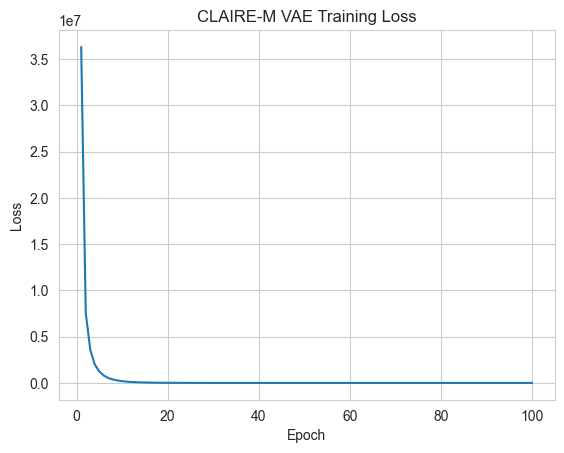

In [52]:
sns.set_style('whitegrid')
plt.plot(range(1, len(vae_train_loss) + 1), vae_train_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CLAIRE-M VAE Training Loss")
plt.show()

Save:

In [53]:
os.makedirs("../models/adult", exist_ok=True)

In [54]:
torch.save(vae.state_dict(), "../models/adult/sex_cf_vae.pth")

## Generate Counterfactuals

In [55]:
from src.generate_counterfactuals import claire_vae

In [ ]:
cf_df = claire_vae(vae, train_dataset, sensitive_groups=[0, 1], num_samples=500)

In [ ]:
cf_df['age'] = (cf_df['age'] // 10) * 10  # convert age to decade

In [120]:
len(cf_df), len(train_df)

(29306, 14653)

In [130]:
assert len(cf_df) == 2 * len(train_df)  # 2 counterfactuals per sample

In [131]:
cf_df.head()

,education_num,age,sex,income
0,9.920982,20.0,0,0.0
1,4.997179,50.0,0,0.0
2,9.270930,50.0,0,0.0
3,9.659889,30.0,0,0.0
4,13.132423,50.0,0,0.0


In [136]:
cf_df.to_csv("../data/adult/train_basis_cf.csv", index=False)

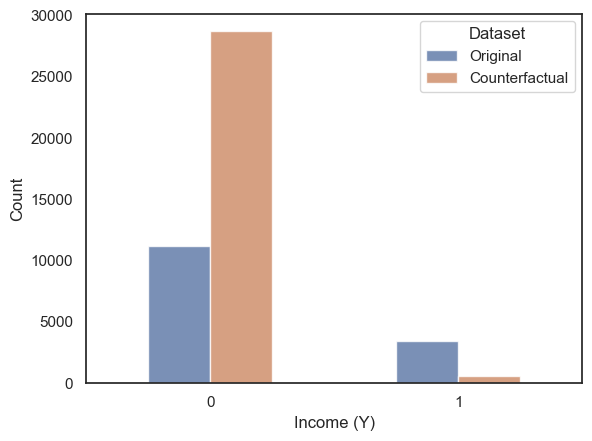

In [132]:
income_counts_orig = train_df.income.value_counts().reset_index()
income_counts_orig["Dataset"] = "Original"
income_counts_cf = cf_df.income.value_counts().reset_index()
income_counts_cf["Dataset"] = "Counterfactual"
income_counts = pd.concat([income_counts_orig, income_counts_cf], ignore_index=True)
income_counts["income"] = income_counts["income"].astype(int)

sns.set(font_scale=1) 
sns.set_style("white")
sns.barplot(data=income_counts, x="income", y="count", hue="Dataset", width=0.5, alpha=0.8)
plt.xlabel("Income (Y)")
plt.ylabel("Count")
plt.show()

In [133]:
# sns.set(font_scale=1.5) 
# sns.set_style("white")

# orig_df_long = pd.melt(train_df, id_vars=["sex"], var_name="variable", value_name="value")
# sns.displot(orig_df_long, x="value", hue="sex", col="variable", kind="kde", fill=True, 
#             facet_kws=dict(sharey=False, sharex=False), height=5, aspect=1.3)

In [134]:
# sns.set(font_scale=1.5) 
# sns.set_style("white")

# cf_df_long = cf_df.melt(id_vars=["sex"], var_name="variable", value_name="value")
# g = sns.displot(cf_df_long, x="value", col="variable", hue="sex", kind="kde", fill=True,
#                 facet_kws=dict(sharey=False, sharex=False), height=5, aspect=1.3)

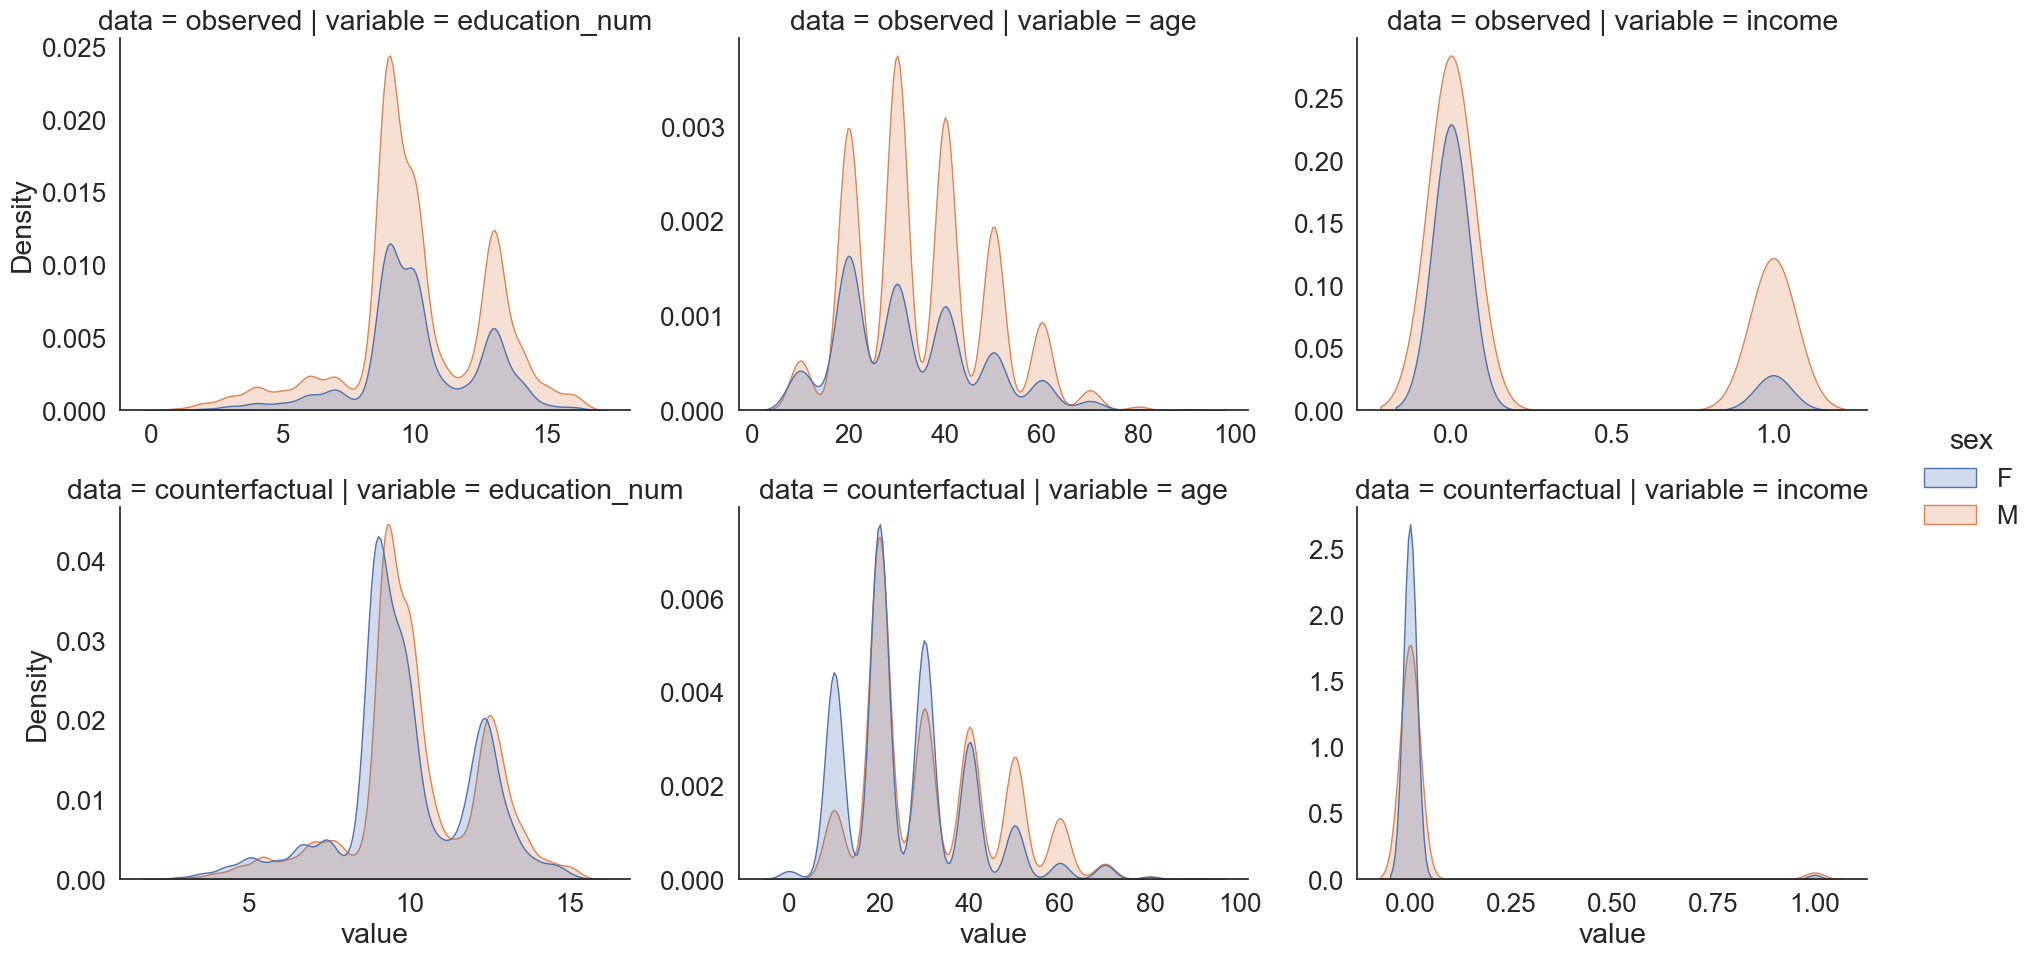

In [135]:
orig_df_long = train_df.melt(id_vars=["sex"], var_name="variable", value_name="value")
cf_df_long = cf_df.melt(id_vars=["sex"], var_name="variable", value_name="value")

orig_df_long["data"] = "observed"
cf_df_long["data"] = "counterfactual"
data_long = pd.concat([orig_df_long, cf_df_long], ignore_index=True)

data_long["sex"] = data_long["sex"].astype(int).map(lambda x: "M" if x == 1 else "F")

sns.set(font_scale=1.7) 
sns.set_style("white")
g = sns.displot(data_long, x="value", col="variable", row="data", hue="sex", kind="kde", fill=True,
                facet_kws=dict(sharey=False, sharex=False), height=5, aspect=1.3)